In [11]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

In [2]:
try:
    dataProtein = pd.read_csv('../alphamissense/human/AlphaMissense_aa_substitutions.tsv', sep='\t', header=3)
except pd.errors.ParserError as e:
    print(f"Errore durante il parsing del file: {e}")

In [3]:
regex = r'([A-Za-z]+)(\d+)([A-Za-z]+)'
dataProtein[['wildtype', 'position', 'mutation']] = dataProtein['protein_variant'].str.extract(regex)
dataProtein.drop(columns=['protein_variant'], inplace=True)

In [4]:
dataHPMdb = pd.read_csv('../dataset/database.tsv', sep='\t')

In [5]:
dataProtein['position'] = dataProtein['position'].astype(int)

data = pd.merge(dataHPMdb, dataProtein, on=['uniprot_id', 'wildtype', 'position', 'mutation'], how='inner')
data.head()

,uniprot_id,wildtype,position,mutation,pdb_id,pdb_pos,phenotypic_annotation,interaction,binding,function,...,acetylation,other_ptm,methylation,ribosylation,subcell_localization_change,mimetic_ptm,folding,expression,am_pathogenicity,am_class
0,P31749,K,8,R,1unp:A,8,"Substantial reduction of ubiquitination, phosp...",NaN,NaN,-1.0,...,NaN,NaN,NaN,NaN,1.0,NaN,NaN,NaN,0.1127,benign
1,P31749,K,14,A,1unp:A,14,"Impairs interaction with PtdIns(3,4,5)P3 and P...",NaN,-1.0,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.9986,pathogenic
2,P31749,K,14,Q,1unp:A,14,Substantial reduction of phosphorylation at T-...,NaN,-1.0,-1.0,...,NaN,NaN,NaN,NaN,1.0,NaN,NaN,NaN,0.9977,pathogenic
3,P31749,K,14,R,1unp:A,14,"Substantial reduction of ubiquitination, phosp...",NaN,-1.0,-1.0,...,NaN,NaN,NaN,NaN,1.0,NaN,NaN,NaN,0.8666,pathogenic
4,P31749,E,17,K,1unp:A,17,No effect on membrane localization. Loss of me...,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.9977,pathogenic


In [6]:
data.drop(columns=['pdb_id', 'pdb_pos', 'phenotypic_annotation'], inplace=True)

In [7]:
mapping = {"pathogenic": -1, "ambiguous": 0, "benign": 1}
data["am_class"] = data["am_class"].map(mapping)
data.drop(columns=['am_pathogenicity'], inplace=True)

In [8]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7572 entries, 0 to 7571
Data columns (total 20 columns):
 #   Column                       Non-Null Count  Dtype  
---  ------                       --------------  -----  
 0   uniprot_id                   7572 non-null   object 
 1   wildtype                     7572 non-null   object 
 2   position                     7572 non-null   int64  
 3   mutation                     7572 non-null   object 
 4   interaction                  2416 non-null   float64
 5   binding                      1402 non-null   float64
 6   function                     3739 non-null   float64
 7   phosphorylation              269 non-null    float64
 8   ubiquination                 114 non-null    float64
 9   glycosylation                81 non-null     float64
 10  sumoylation                  32 non-null     float64
 11  acetylation                  0 non-null      float64
 12  other_ptm                    74 non-null     float64
 13  methylation       

# Analysis

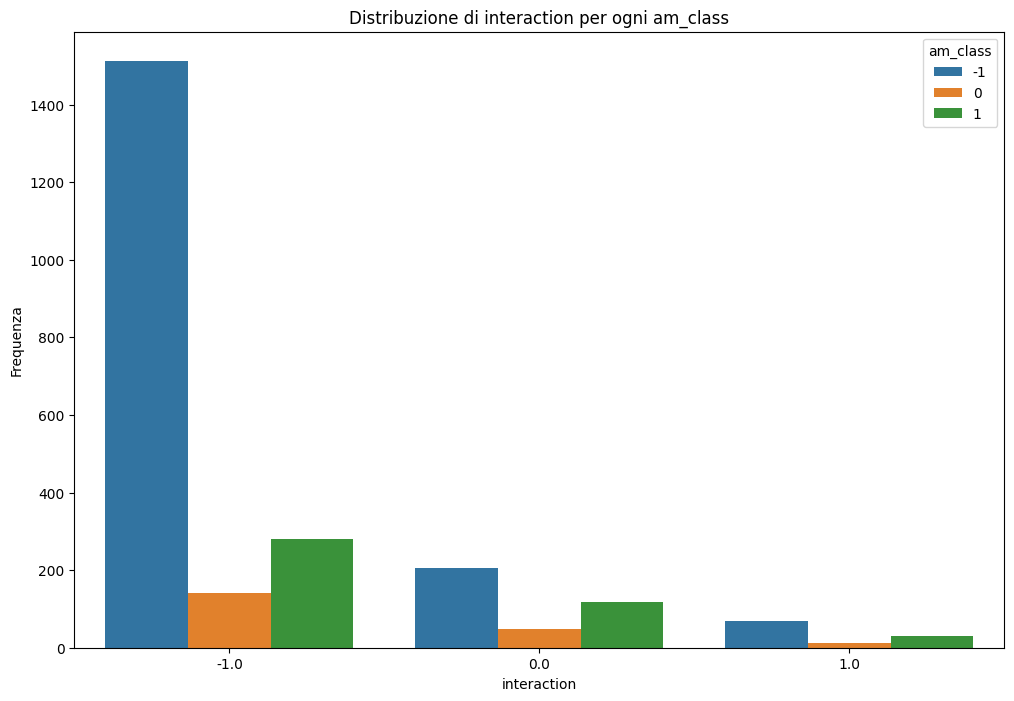

In [15]:
plt.figure(figsize=(12, 8))
sns.countplot(x='interaction', 
              hue='am_class', 
              data=data)
plt.title('Distribuzione di interaction per ogni am_class')
plt.xlabel('Interaction')
plt.ylabel('Frequenza')
plt.show()

# Correlation

In [49]:
from scipy import stats

columns_to_compare = ['function', 'interaction', 'binding', 'phosphorylation', 'ubiquination', 'glycosylation', 
                      'sumoylation', 'other_ptm', 'ribosylation', 'subcell_localization_change', 'expression']

correlation_table = pd.DataFrame(index=["am_class"])

for column in columns_to_compare:
    data_filtered = data[~data[column].isna()]
    pearson_corr = stats.pearsonr(data_filtered["am_class"], data_filtered[column])
    correlation_table[column] = [pearson_corr[0]]

/data/fsartori/MolecularPhenotypes/venv/lib/python3.8/site-packages/scipy/stats/_stats_py.py:4424: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(msg))


In [50]:
correlation_table

,function,interaction,binding,phosphorylation,ubiquination,glycosylation,sumoylation,other_ptm,ribosylation,subcell_localization_change,expression
am_class,0.267209,0.174224,0.153606,0.05538,0.037061,-0.270199,0.272554,-0.078731,NaN,-0.252634,-0.208394
